In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import time
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image

from fastai import *
from fastai.vision import *
from fastai.vision.all import *

import gc
from tqdm.auto import *
from IPython.display import clear_output

In [2]:
def optimal_device():
    print("Checking for CUDA availability")
    if torch.cuda.is_available():
        print("CUDA is available")
        return torch.device('cuda')
    else:
        print("CUDA is NOT available")
        try:
            dev = torch.device('mps')
            print("Fallbacking to to use MPS")
            return dev
        except Exception as _:
            print("Fallbacking to CPU")
            return torch.device('cpu')


In [3]:
device = optimal_device()
selected_dtype = torch.float32

Checking for CUDA availability
CUDA is NOT available
Fallbacking to to use MPS


# Model definition

In [4]:
from functools import reduce
import torch
import torch.nn as nn
import torchvision

class ConvBlock(nn.Module):
    """
    Helper module that consists of a Conv -> BN -> ReLU
    """
    def __init__(self, in_channels, out_channels, padding=1, kernel_size=3, stride=1, with_nonlinearity=True):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, padding=padding, kernel_size=kernel_size, stride=stride)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.with_nonlinearity = with_nonlinearity

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        if self.with_nonlinearity:
            x = self.relu(x)
        return x
    
class UpBlock(nn.Module):
    """
    Up block that encapsulates one up-sampling step which consists of Upsample -> ConvBlock
    """

    def __init__(self, in_channels, out_channels, up_conv_in_channels=None, up_conv_out_channels=None,
                 upsampling_method="conv_transpose"):
        super().__init__()

        if up_conv_in_channels == None:
            up_conv_in_channels = in_channels
        if up_conv_out_channels == None:
            up_conv_out_channels = out_channels

        if upsampling_method == "conv_transpose":
            self.upsample = nn.ConvTranspose2d(up_conv_in_channels, up_conv_out_channels, kernel_size=2, stride=2)
        elif upsampling_method == "bilinear":
            self.upsample = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
            )
        self.conv_block = ConvBlock(out_channels, out_channels)

    def forward(self, up_x):
        x = self.upsample(up_x)
        x = self.conv_block(x)
        return x


class ResNet50Autoencoder(nn.Module):
    def __init__(self, latent_channels=2048, float_type=selected_dtype):
        super().__init__()

        self.float_type = float_type

        resnet = torchvision.models.resnet.resnet50(weights='ResNet50_Weights.DEFAULT')
        down_blocks = []
        up_blocks = []

        self.input_block = nn.Sequential(*list(resnet.children()))[:3] # Conv2D, BatchNorm2D, ReLU
        self.input_pool = list(resnet.children())[3]

        for bottleneck in list(resnet.children()):
            if isinstance(bottleneck, nn.Sequential):
                down_blocks.append(bottleneck)

        self.down_blocks = nn.ModuleList(down_blocks)
        
        self.to_latent = ConvBlock(2048, latent_channels)


        self.from_latent = ConvBlock(latent_channels, 2048)

        up_blocks.append(UpBlock(2048, 1024))
        up_blocks.append(UpBlock(1024, 512))
        up_blocks.append(UpBlock(512, 256))
        up_blocks.append(UpBlock(in_channels=128 + 64, out_channels=128,
                                                    up_conv_in_channels=256, up_conv_out_channels=128))
        up_blocks.append(UpBlock(in_channels=64 + 3, out_channels=64,
                                                    up_conv_in_channels=128, up_conv_out_channels=64))

        self.up_blocks = nn.ModuleList(up_blocks)

        self.out = nn.Conv2d(64, 3, kernel_size=1, stride=1)

        self.to(self.float_type)
        
    def encode(self, x):
        x = x.to(self.float_type)
        
        x = self.input_block(x)
        x = self.input_pool(x)

        for _, block in enumerate(self.down_blocks, 2):
            x = block(x)

        x = self.to_latent(x)

        x = torch.sigmoid(x)

        total = reduce((lambda x, y: x * y), x.shape[1:])

        return x
        
    def decode(self, x):
        x = self.from_latent(x)

        for _, block in enumerate(self.up_blocks, 1):
            x = block(x)

        x = self.out(x)

        return x

In [5]:
class Quantization:
    pass

In [6]:
class NormNoiseQuantization(nn.Module, Quantization):
    def __init__(self, quants: int = 2):
        super().__init__()
        self.quants = quants

    def forward(self, x):
        x = x + ((torch.rand_like(x, requires_grad=True) - 0.5) / (2 ** self.quants))
        return x

In [7]:
class DigitQuantization(nn.Module, Quantization):
    def __init__(self, quants: int = 2, orig_type = selected_dtype, q_type = torch.int8):
        super().__init__()
        self.quants = quants
        self.orig_type = orig_type
        self.q_type = q_type

    def forward(self, x):
        return torch.round(x.detach() * (2 ** self.quants) + 0.5).to(self.q_type)
    
    def backward(self, x):
        return x.to(self.orig_type) / (2 ** self.quants)

In [8]:
# quantization = NormNoiseQuantization(2)

# model = ResNet50Autoencoder(1024, float_type=torch.float32).to(device)
# inp = torch.rand((2, 3, 512, 512)).to(device)

# latent = model.encode(inp)

# quantized = quantization(latent)

# out = model.decode(quantized)

# Dataset loader

In [9]:
folder = "data"
path_data = pd.read_csv(f"{folder}/train.csv")
print("Was")
print(path_data.head(5))
path_data['path'] = path_data['label'] + "/" + path_data['image_name']
path_data = path_data.drop(['image_name'], axis=1).reindex(columns=['path', 'label'])
path_data.to_csv(f"{folder}/labels.csv", index=False)
print("Modified")
print(path_data.head(5))
del(path_data)

Was
      image_name    label
0  image0000.jpg  apparel
1  image0001.jpg  apparel
2  image0002.jpg  apparel
3  image0003.jpg  apparel
4  image0004.jpg  apparel
Modified
                    path    label
0  apparel/image0000.jpg  apparel
1  apparel/image0001.jpg  apparel
2  apparel/image0002.jpg  apparel
3  apparel/image0003.jpg  apparel
4  apparel/image0004.jpg  apparel


In [10]:
dataloader = ImageDataLoaders.from_csv("data/", bs = 4, valid_pct=0.2, shuffle=True, dtype=selected_dtype)

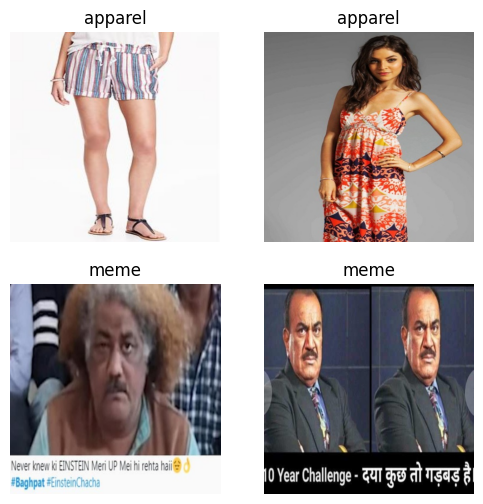

In [11]:
dataloader.show_batch()

# Loss Functions

In [12]:
# MSE
def mse_loss(result, target):
    return F.mse_loss(result, target)

# PSNR
def psnr(result, target):
    mse = mse_loss(result, target)
    return 10 * torch.log10(1 / mse) * (torch.max(result) ** 2)

# Intermediate vector entropy
def latent_entropy_aprox(result):
    probabilities = F.softmax(result, dim=1)
    entropy = F.cross_entropy(probabilities, torch.ones_like(probabilities) / probabilities.size(1))
    return entropy

# Perseptual loss
class VGGFeatures(nn.Module):
    def __init__(self, feature_layers = {3, 6, 11, 16}):
        super(VGGFeatures, self).__init__()
        vgg = torchvision.models.vgg11(weights="VGG11_Weights.DEFAULT")
        vgg.eval()
        for param in vgg.parameters():
            param.requires_grad = False

        self.vgg = vgg
        self.feature_layers = feature_layers

    def forward(self, x):
        features = []
        for i, layer in enumerate(self.vgg.features):
            x = layer(x)
            if i in self.feature_layers:
                features.append(x)
        return features

vgg_features = VGGFeatures()
def vgg_perceptual_loss(result, target, vgg_to_use=vgg_features):
    result = vgg_to_use(result)
    target = vgg_to_use(target)
    return sum(F.mse_loss(orig, decomp) for orig, decomp in zip(result, target))

# Example
# mse_loss(out, inp), psnr(out, inp), latent_entropy_aprox(quantized), vgg_perceptual_loss(out, inp)

In [13]:
gc.collect()

114980

# Train loop

In [14]:
def save_model(model: ResNet50Autoencoder, path: str, prefix: str, offset: int, epoch: int, loss: float, optimizer):
    loss_repr = str(loss).replace(".", ",")
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'loss': loss,
        'optimizer_state_dict': optimizer.state_dict()
    }, f"{path}/{prefix}_model_{offset + epoch}_l_{loss_repr}.pth")

def validate(model: ResNet50Autoencoder, valid_quantization: Quantization, dataloader: DataLoader):
    mse_losses = []
    psnr_losses = []
    latent_entropies = []
    vgg_perceptual_losses = []
    
    model.eval()
    
    for batch, _ in tqdm(dataloader.valid, total=len(dataloader.valid), desc="Validation"):
        batch = batch.to(selected_dtype)
        
        latent = model.encode(batch)
        quantized = valid_quantization(latent)
        out = model.decode(quantized)

        mse_losses.append(mse_loss(out, batch))
        psnr_losses.append(psnr(out, batch))
        latent_entropies.append(latent_entropy_aprox(quantized))
        vgg_perceptual_losses.append(vgg_perceptual_loss(out, batch))

    return (sum(mse_losses) / len(mse_losses),
            sum(psnr_losses) / len(psnr_losses),
            sum(latent_entropies) / len(latent_entropies),
            sum(vgg_perceptual_losses) / len(vgg_perceptual_losses))

def train_loop(model: ResNet50Autoencoder,
               train_quantization: Quantization,
               valid_quantization: Quantization,
               offset: int,
               epochs: int,
               dataloader: DataLoader,
               optimizer):
               
    mse_losses = []
    psnr_losses = []
    latent_entropies = []
    vgg_perceptual_losses = []
    
    started_time = time.time()

    for epoch in range(epochs):
        # Resource management
        collected = gc.collect()
        print(f"Trashed {collected} objects")

        print(f"Epoch {epoch + 1} of {epochs}. Total time: {time.time() - started_time}")
        
        model.train()

        # Epoch Train loop
        for batch, _ in tqdm(dataloader.train, total=len(dataloader.train), desc="Training"):
            batch = batch.to(selected_dtype)
            
            optimizer.zero_grad()
            
            latent = model.encode(batch)
            quantized = train_quantization(latent)
            out = model.decode(quantized)

            loss = mse_loss(out, batch)
            loss.backward()
            optimizer.step()

            out_t = out.detach()
            batch_t = batch.detach()
            quantized_t = quantized.detach()

            mse_losses.append(loss.numpy())
            psnr_losses.append(psnr(out_t, batch_t).numpy())
            latent_entropies.append(latent_entropy_aprox(quantized_t).numpy())
            vgg_perceptual_losses.append(vgg_perceptual_loss(out_t, batch_t).numpy())

        # Print losses
        _, axs = plt.subplots(1, 4, figsize=(16, 2))

        for axis in axs:
            axis.clear()
            axis.grid(True)
            axis.set_xlabel(f'# Batches (bs: {dataloader.bs})')
            axis.set_ylabel('Loss')
            axis.axhline(0, color='black', lw=1)
            axis.axvline(0, color='black', lw=1)

        # plot mse_losses on the first subplot
        axs[0].plot(mse_losses)
        axs[0].scatter(len(mse_losses) - 1, mse_losses[-1], color='red')
        axs[0].set_title('MSE Loss')

        # plot psnr_losses on the second subplot
        axs[1].plot(psnr_losses)
        axs[1].scatter(len(psnr_losses) - 1, psnr_losses[-1], color='red')
        axs[1].set_title('PSNR Loss')

        # plot latent_entropies on the third subplot
        axs[2].plot(latent_entropies)
        axs[2].scatter(len(latent_entropies) - 1, latent_entropies[-1], color='red')
        axs[2].set_title('Latent Entropy')

        # plot vgg_perceptual_losses on the fourth subplot
        axs[3].plot(vgg_perceptual_losses)
        axs[3].scatter(len(vgg_perceptual_losses) - 1, vgg_perceptual_losses[-1], color='red')
        axs[3].set_title('VGG Perceptual Loss')

        # adjust the spacing between subplots
        plt.subplots_adjust(hspace=0.5)

        # show the plot
        plt.show()


        # Validation
        v_mse, v_psnr, v_entropy, v_perceptual = validate(model, valid_quantization, dataloader)
        print(f"Validation: MSE: {v_mse}, PSNR: {v_psnr}, Entropy: {v_entropy}, Perceptual: {v_perceptual}")

        # Save model
        save_model(model, "weights", "mse_resnet50", offset, epoch, v_mse, optimizer)
        

In [15]:
model = ResNet50Autoencoder(128, float_type=selected_dtype).to(device)

train_quantization = NormNoiseQuantization(6).to(device)

valid_quantization = DigitQuantization(6, orig_type=selected_dtype, q_type=torch.int32).to(device)

from torch.optim import Adam

adam_optim = Adam(model.parameters(), lr=1e-3)

In [ ]:
train_loop(model, train_quantization, valid_quantization, offset=0, epochs=10, dataloader=dataloader, optimizer=adam_optim)

Trashed 9 objects
Epoch 1 of 10. Total time: 0.06556105613708496


Training:   0%|          | 0/26505 [00:00<?, ?it/s]

AttributeError: 'numpy.ndarray' object has no attribute 'imshow'

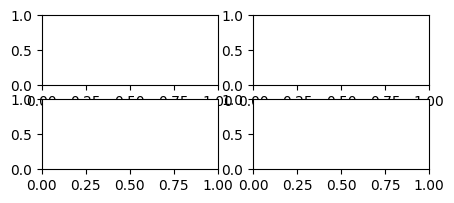

In [10]:
_, axs = plt.subplots(2, 2, figsize=(5, 2))

axs[0].imshow(torch.rand(3, 512, 512).permute(1, 2, 0).numpy())

In [16]:
x = torch.tensor([[1,2,3], [4,5,6]])

In [17]:
x.shape

torch.Size([2, 3])

In [40]:
x = torch.rand(10, 3, 4, 5)  # For example purposes, creating a tensor of shape [10, 3, 4, 5]

# Take the max of each element in the batch
torch.nn.functional.mse_loss(x.view(x.size(0), -1), torch.rand(10, 3, 4, 5).view(x.size(0), -1) + 1, reduction='none')

tensor([[0.8669, 0.8073, 1.4958, 0.7068, 0.6762, 1.1769, 0.9538, 0.0454, 0.2809,
         2.9428, 1.9361, 1.8165, 1.2989, 0.7063, 0.3507, 1.5910, 0.8079, 1.0128,
         2.5426, 0.0672, 1.3417, 0.7803, 1.2274, 1.8381, 2.6197, 1.2721, 0.2803,
         0.2525, 1.3938, 1.7711, 1.4190, 0.2061, 3.0478, 0.7475, 0.0840, 0.6385,
         0.0996, 1.8784, 0.6279, 0.9945, 0.1902, 0.4184, 0.3362, 1.9628, 0.0945,
         0.6587, 0.7984, 1.4711, 1.3363, 1.5874, 0.6767, 1.5255, 2.0554, 0.8158,
         0.2585, 0.2388, 3.3945, 0.1396, 1.5710, 2.0803],
        [0.8460, 0.3426, 1.9207, 1.6742, 2.0848, 0.9134, 0.4882, 1.7324, 1.3154,
         1.2242, 0.2115, 3.0327, 0.8564, 0.5384, 1.7117, 0.3569, 1.4333, 1.6903,
         1.6936, 1.2376, 0.6465, 0.3928, 2.4269, 2.6811, 2.2284, 2.7747, 0.9735,
         0.8814, 0.0327, 0.9729, 1.6159, 0.5531, 0.9303, 0.9961, 1.3345, 0.2571,
         0.1648, 0.5321, 1.1817, 0.9588, 0.0128, 1.4341, 2.0038, 0.1308, 1.8084,
         0.2546, 0.5942, 1.8466, 0.7726, 0.9990, 1.

In [26]:
x = torch.rand(2, 3, 4)
x

tensor([[[0.3268, 0.8247, 0.6712, 0.0638],
         [0.7219, 0.0213, 0.5150, 0.2749],
         [0.9248, 0.1594, 0.7867, 0.0747]],

        [[0.9554, 0.3238, 0.3652, 0.2616],
         [0.8324, 0.1732, 0.9176, 0.3356],
         [0.5673, 0.2645, 0.7322, 0.1632]]])

In [34]:
torch.log(torch.tensor([1.0, 2, 3]) ** 2)

tensor([0.0000, 1.3863, 2.1972])